In [ ]:
#@title Download data and prepare our environment { display-mode: "form" }
!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

%matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

--2023-07-24 18:27:28--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv.2’

finance_test.csv.2  100%[===================>]  28.58K  --.-KB/s    in 0s      

2023-07-24 18:27:29 (104 MB/s) - ‘finance_test.csv.2’ saved [29264/29264]

--2023-07-24 18:27:29--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.co

In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
sentences = df_train['Sentence'].values
labels = df_train['Label'].values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [ ]:
print(tokenizer.vocab_size)

30522


In [ ]:
original_sentence = sentences[0]
tokenized_sentence = tokenizer.tokenize(original_sentence)
print('Original Sentence: ', original_sentence)
print('Tokenized Sentence: ', tokenized_sentence)

Original Sentence:  Autotank Group is part of Aspo 's Systems Division .
Tokenized Sentence:  ['auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.']


In [ ]:
original_sentence = sentences[0]
tokenized_sentence = tokenizer.tokenize(original_sentence)
print('Tokenized Sentence: ', tokenized_sentence)
print('Mapped Indices Sentence: ', tokenizer.convert_tokens_to_ids(tokenized_sentence))

Tokenized Sentence:  ['auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.']
Mapped Indices Sentence:  [8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012]


In [ ]:
sentences_with_special_tokens = []
for sentence in sentences:
  new_sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)
print(sentences_with_special_tokens[0])

[CLS] Autotank Group is part of Aspo 's Systems Division . [SEP]


In [ ]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  tokenized_sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(tokenized_sentence)
print(tokenized_texts[0])

['[CLS]', 'auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.', '[SEP]']


In [ ]:
input_ids = []
for text in tokenized_texts:
  new_list = tokenizer.convert_tokens_to_ids(text)
  input_ids.append(new_list)
print(input_ids[0])

[101, 8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012, 102]


In [ ]:
input_ids = pad_sequences(input_ids,
                          maxlen=128,
                          dtype="long",
                          truncating="post",
                          padding="post")
print(input_ids[0])

[ 101 8285 5794 2243 2177 2003 2112 1997 2004 6873 1005 1055 3001 2407
 1012  102    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
attention_masks = []
for sequence in input_ids:
  mask = [float(i > 0) for i in sequence]
  attention_masks.append(mask)
print (attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids,
                                                  labels,
                                                  test_size=0.15,
                                                  random_state=RND_SEED)

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       test_size=0.15,
                                                       random_state=RND_SEED)

In [ ]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data);
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data);
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
);

model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'Tesla T4'

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

In [ ]:
_1_ = '' #@param {type:"string"}
_2_ = '' #@param {type:"string"}
_3_ = '' #@param {type:"string"}
_4_ = '' #@param {type:"string"}
_5_ = '' #@param {type:"string"}

print('{}\n{}\n{}\n{}\n{}'.format(
    '1. Unpack our data inputs and labels from the DataLoader objects',
    '2. Clear out the gradients calculated in the previous pass',
    '3. Forward pass',
    '4. Backward pass',
    '5. Update hyperparamters'))

1. Unpack our data inputs and labels from the DataLoader objects
2. Clear out the gradients calculated in the previous pass
3. Forward pass
4. Backward pass
5. Update hyperparamters


In [ ]:
#@title Run this cell to train model
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# loss, validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("Evaluating on Validation Set")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():

            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.64
Evaluating on Validation Set
Validation Accuracy: 0.93
Validation Loss: 0.31
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.18
Evaluating on Validation Set
Validation Accuracy: 0.93
Validation Loss: 0.18
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.07
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.13
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.04
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.14
Training complete!


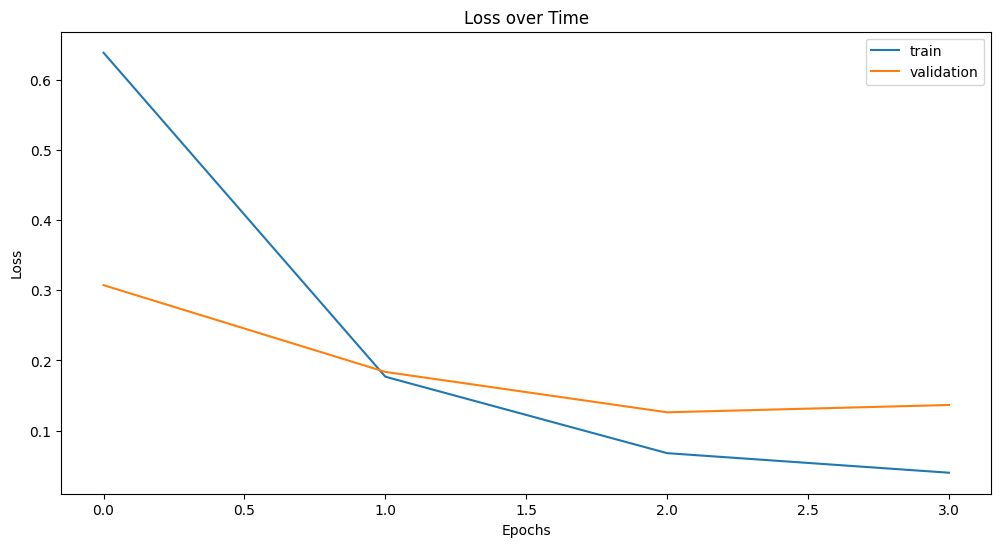

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label='train')
plt.plot(validation_loss, label='validation')

plt.legend()
plt.show()

In [ ]:
test_sentences = df_test.Sentence.values
test_labels = df_test.Label.values

In [ ]:
test_input_ids, test_attention_masks = [], []
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 97.80%
Plotting the Confusion Matrix


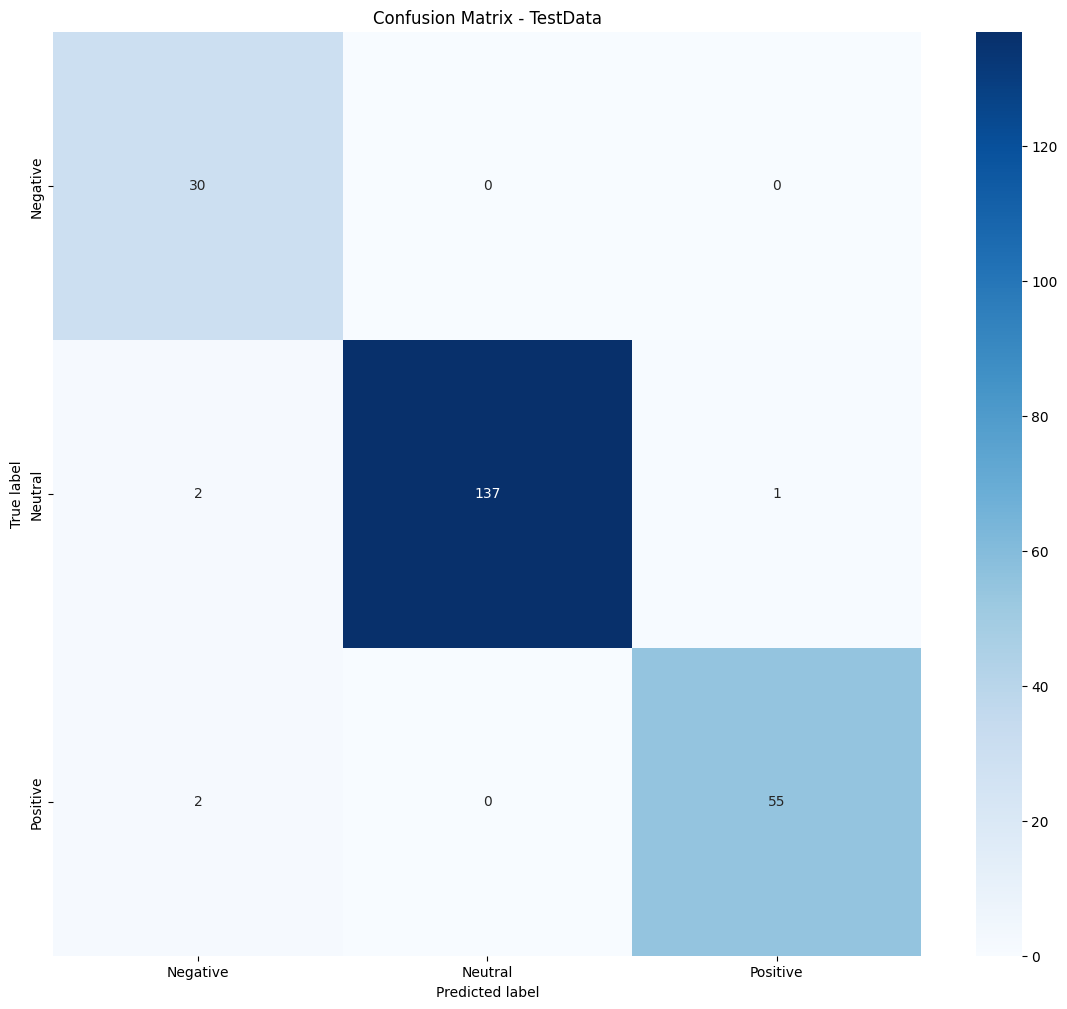

In [ ]:
#@title Evaluate Test Set Accuracy

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

y_logits, y_true, y_preds = [], [], []

for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)